In [1]:
# pip install torch matplotlib numpy scikit-learn h5py joblib

In [2]:
import os
import shutil
import glob
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
import h5py
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
print(torch.__version__)

2.6.0


In [4]:
# # Training configuration
# config = {
#     'batch_size': 256,
#     'lr': 3e-4,
#     'epochs': 50,
#     'weight_decay': 1e-6,
#     'patience': 15
# }

model_name = "fossen_net_1"
data_path = "data.h5"
SAMPLES_PER_SCENARIO = 100

if os.path.exists(model_name):
    pt_files = glob.glob(os.path.join(model_name, "*.pt"))
    if pt_files:
        sys.exit(f"ERROR: Trained model found in '{model_name}'! Aborting to avoid overwrite.")
    else:
        shutil.rmtree(model_name)
        os.makedirs(model_name)
        print(f"Model folder '{model_name}' recreated (no trained model found).")
else:
    # Create folder if it doesn't exist
    os.makedirs(model_name)
    print(f"Model folder '{model_name}' created successfully.")

config = {
    'batch_size': 256,          # 128 -> 256
    'lr': 3e-4,                 # Lower learning rate
    'epochs': 50,               # Increased epochs to allow for slower convergence
    'weight_decay': 1e-6,
    'patience': 20,
    'optimizer': 'Adam',        # Switch to Adam
    'loss_function': 'Huber'    # Use HuberLoss
}

Model folder 'fossen_net_1' recreated (no trained model found).


In [5]:

def visualize_results(targets_denorm, predictions_denorm):
    # Create subplots for scatter plots
    plt.figure(figsize=(18, 20))
    
    print("Targets shape:", targets_denorm.shape)
    print("Predictions shape:", predictions_denorm.shape)

    # Scatter plots of True vs Predicted values
    for i in range(8):
        plt.subplot(4, 2, i+1)
        true = targets_denorm[:, i]
        pred = predictions_denorm[:, i]
        plt.scatter(true, pred, alpha=0.3, label='Samples')
        plt.plot([min(true), max(true)], [min(true), max(true)], 'r--', label='Perfect Prediction')
        plt.xlabel(f'True Value (Thruster {i+1})')
        plt.ylabel(f'Predicted Value (Thruster {i+1})')
        plt.title(f'Thruster {i+1} - True vs Predicted')
        plt.legend()
        plt.grid(True)

        # Add R² and MAE to plot
        r2 = r2_score(true, pred)
        mae = mean_absolute_error(true, pred)
        plt.text(0.05, 0.9, f'R²: {r2:.2f}\nMAE: {mae:.2f}',
                transform=plt.gca().transAxes,
                bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(f'{model_name}/true_vs_predicted_scatter.png')
    plt.show()

    # Create sample comparison plot (first 100 samples)
    plt.figure(figsize=(18, 20))
    sample_indices = np.arange(100)

    for i in range(8):
        plt.subplot(4, 2, i+1)
        plt.plot(sample_indices, targets_denorm[:100, i], 'b-', label='True')
        plt.plot(sample_indices, predictions_denorm[:100, i], 'r--', label='Predicted')
        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.title(f'Thruster {i+1} - First 100 Samples')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{model_name}/sample_comparison.png')
    plt.show()

    # Residuals distribution
    plt.figure(figsize=(18, 20))
    residuals = targets_denorm - predictions_denorm

    for i in range(8):
        plt.subplot(4, 2, i+1)
        plt.hist(residuals[:, i], bins=50, alpha=0.7)
        plt.xlabel('Residual (True - Predicted)')
        plt.ylabel('Frequency')
        plt.title(f'Thruster {i+1} - Residual Distribution')
        plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{model_name}/residual_distribution.png')
    plt.show()

In [6]:
import boto3

s3 = boto3.client('s3')
bucket_name = "sagemaker-eu-south-1-590184046456"
key = "data.h5"
local_path = "data.h5"

s3.download_file(bucket_name, key, local_path)

import h5py
with h5py.File(local_path, 'r') as f:
    print(list(f.keys()))

['u_opt', 'x_current', 'x_ref']


In [7]:
with h5py.File(data_path, 'r') as hf:
    num_samples = hf['x_current'].shape[0]
    num_scenarios = num_samples // SAMPLES_PER_SCENARIO
    scenario_ids = np.arange(num_scenarios)

# Train / Val / Test split
train_val_ids, test_ids = train_test_split(
    scenario_ids, test_size=0.2, shuffle=True, random_state=42
)
train_ids, val_ids = train_test_split(
    train_val_ids, test_size=0.25, shuffle=True, random_state=42
)  # 0.25 * 0.8 = 0.2

def scenario_ids_to_indices(scenario_ids):
    return np.concatenate([
        np.arange(i * SAMPLES_PER_SCENARIO, (i + 1) * SAMPLES_PER_SCENARIO)
        for i in scenario_ids
    ])

train_indices = scenario_ids_to_indices(train_ids)
val_indices = scenario_ids_to_indices(val_ids)
test_indices = scenario_ids_to_indices(test_ids)

print(f"Total scenarios: {num_scenarios}")
print(f"Train scenarios: {len(train_ids)}, Val scenarios: {len(val_ids)}, Test scenarios: {len(test_ids)}")

# -----------------------
# Step 2: Fit scalers using only train set
# -----------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()

with h5py.File(data_path, 'r') as hf:
    # Read only train data in chunks to fit scalers
    for idx in train_indices:
        x_current = hf['x_current'][idx]
        x_ref = hf['x_ref'][idx]
        u_opt = hf['u_opt'][idx]

        # Preprocessing
        x_path_3d = x_ref.reshape(12, 41).T  # (41, 12)
        pos_array = np.zeros(12, dtype=np.float32)
        pos_array[:3] = x_current[:3]
        x_path_3d -= pos_array
        x_ref_relative = x_path_3d.T.reshape(-1)

        X_sample = np.hstack((x_current[3:], x_ref_relative)).astype(np.float32)
        y_sample = u_opt.astype(np.float32)

        scaler_X.partial_fit(X_sample.reshape(1, -1))
        scaler_y.partial_fit(y_sample.reshape(1, -1))

# Save scalers
joblib.dump(scaler_X, f'{model_name}/scaler_X.gz')
joblib.dump(scaler_y, f'{model_name}/scaler_y.gz')
print("Fitted scalers have been saved.")

# -----------------------
# Step 3: Dataset class for lazy loading
# -----------------------
class H5Dataset(Dataset):
    def __init__(self, file_path, indices, scaler_X, scaler_y):
        self.file_path = file_path
        self.indices = indices
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y
        self.hf = None  # will open in __getitem__

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        if self.hf is None:
            self.hf = h5py.File(self.file_path, 'r')

        data_idx = self.indices[idx]
        x_current = self.hf['x_current'][data_idx]
        x_ref = self.hf['x_ref'][data_idx]
        u_opt = self.hf['u_opt'][data_idx]

        # Preprocessing (same as original)
        x_path_3d = x_ref.reshape(12, 41).T
        pos_array = np.zeros(12, dtype=np.float32)
        pos_array[:3] = x_current[:3]
        x_path_3d -= pos_array
        x_ref_relative = x_path_3d.T.reshape(-1)

        X = np.hstack((x_current[3:], x_ref_relative)).astype(np.float32)
        y = u_opt.astype(np.float32)

        # Normalize
        X_norm = self.scaler_X.transform(X.reshape(1, -1)).squeeze(0)
        y_norm = self.scaler_y.transform(y.reshape(1, -1)).squeeze(0)

        return torch.from_numpy(X_norm), torch.from_numpy(y_norm)

    def __del__(self):
        if self.hf is not None:
            self.hf.close()

# -----------------------
# Step 4: Create DataLoaders
# -----------------------
train_dataset = H5Dataset(data_path, train_indices, scaler_X, scaler_y)
val_dataset = H5Dataset(data_path, val_indices, scaler_X, scaler_y)
test_dataset = H5Dataset(data_path, test_indices, scaler_X, scaler_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# -----------------------
# Example usage
# -----------------------
for X_batch, y_batch in train_loader:
    print("X batch shape:", X_batch.shape)
    print("y batch shape:", y_batch.shape)
    break

Total scenarios: 3766
Train scenarios: 2259, Val scenarios: 753, Test scenarios: 754
Fitted scalers have been saved.
X batch shape: torch.Size([64, 501])
y batch shape: torch.Size([64, 8])


In [8]:
# Dropout layers are disabled temporarily to see if the training loss drops below the validation loss. If it does, your dropout rates are likely too high.

class FossenNet(nn.Module):
    def __init__(self):
        super(FossenNet, self).__init__()
        # State processing branch (current state: 9 features)
        self.state_net = nn.Sequential(
            nn.Linear(9, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            # nn.Dropout(0.2), # Temporarily disabled
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1)
        )
        
        # Reference trajectory processing (492 features -> 41 timesteps x 12 features)
        self.lstm = nn.LSTM(
            input_size=12,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=0.2  # Note: This dropout is within the LSTM layers and is often beneficial
        )
        self.ref_fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1)
        )
        
        # --- MODIFIED: Increased Capacity ---
        # Combined processing
        self.combined_net = nn.Sequential(
            nn.Linear(32 + 64, 256),  # Concatenated features -> Increased width
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            # nn.Dropout(0.3), # Temporarily disabled
            nn.Linear(256, 128),      # Added another layer for more depth
            nn.LeakyReLU(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 8)
        )
        
        # Initialize weights (no changes here)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        param.data.fill_(0)
                        n = param.size(0)
                        param.data[n//4:n//2].fill_(1)

    def forward(self, x):
        state = x[:, :9]
        ref = x[:, 9:9+492]
        
        state_out = self.state_net(state)
        
        batch_size = x.size(0)
        ref = ref.view(batch_size, 41, 12)
        lstm_out, _ = self.lstm(ref)
        ref_out = lstm_out[:, -1, :]
        ref_out = self.ref_fc(ref_out)
        
        combined = torch.cat((state_out, ref_out), dim=1)
        return self.combined_net(combined)

def train(config, train_dataset, val_dataset):
    model = FossenNet()
    
    # --- MODIFIED: Select Loss Function based on config ---
    if config['loss_function'] == 'Huber':
        criterion = nn.HuberLoss()
    else: # Default to MSE
        criterion = nn.MSELoss()

    # --- MODIFIED: Select Optimizer based on config ---
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    else: # Default to AdamW
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], num_workers=2)

    best_loss = float('inf')
    no_improve = 0
    
    print("--- Starting Training ---")
    print(f"Configuration: {config}")

    for epoch in range(config['epochs']):
        # Training phase
        model.train()
        train_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                pred = model(x_val)
                val_loss += criterion(pred, y_val).item()

        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        scheduler.step(avg_val)

        # Early stopping check
        if avg_val < best_loss:
            best_loss = avg_val
            no_improve = 0
            torch.save(model.state_dict(), f'{model_name}/best_model_huber_adam.pth')
        else:
            no_improve += 1

        if no_improve >= config['patience']:
            print(f"Early stopping at epoch {epoch+1}")
            break

        print(f"Epoch {epoch+1}/{config['epochs']} | "
              f"Train Loss: {avg_train:.6f} | Val Loss: {avg_val:.6f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

    model.to('cuda')
    scripted_model = torch.jit.script(model)
    scripted_model.save(f'{model_name}/fossen_net_scripted.pt')

def evaluate_test_set():
    # Load model
    model = FossenNet()
    model.load_state_dict(torch.load(f'{model_name}/best_model_huber_adam.pth'))
    model.eval()

    # Load saved scalers
    scaler_X = joblib.load(f'{model_name}/scaler_X.gz')
    scaler_y = joblib.load(f'{model_name}/scaler_y.gz')

    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)

    predictions = []
    targets = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            pred = model(x_batch)
            predictions.append(pred.numpy())
            targets.append(y_batch.numpy())

    predictions = np.vstack(predictions)
    targets = np.vstack(targets)

    # --- Denormalize (rescale back to original) ---
    predictions_denorm = scaler_y.inverse_transform(predictions)
    targets_denorm = scaler_y.inverse_transform(targets)

    # --- Metrics ---
    metrics = {
        'MAE': mean_absolute_error(targets_denorm, predictions_denorm),
        'MSE': mean_squared_error(targets_denorm, predictions_denorm),
        'RMSE': np.sqrt(mean_squared_error(targets_denorm, predictions_denorm)),
        'R2': r2_score(targets_denorm, predictions_denorm)
    }

    thruster_metrics = []
    for i in range(8):
        thruster_metrics.append({
            'Thruster': i+1,
            'MAE': mean_absolute_error(targets_denorm[:, i], predictions_denorm[:, i]),
            'MSE': mean_squared_error(targets_denorm[:, i], predictions_denorm[:, i]),
            'RMSE': np.sqrt(mean_squared_error(targets_denorm[:, i], predictions_denorm[:, i])),
            'R2': r2_score(targets_denorm[:, i], predictions_denorm[:, i])
        })

    return metrics, thruster_metrics, predictions_denorm, targets_denorm

--- Starting Training ---
Configuration: {'batch_size': 256, 'lr': 0.0003, 'epochs': 50, 'weight_decay': 1e-06, 'patience': 20, 'optimizer': 'Adam', 'loss_function': 'Huber'}
Epoch 1/50 | Train Loss: 0.084887 | Val Loss: 0.050567 | LR: 3.00e-04
Epoch 2/50 | Train Loss: 0.042781 | Val Loss: 0.033144 | LR: 3.00e-04
Epoch 3/50 | Train Loss: 0.031321 | Val Loss: 0.025334 | LR: 3.00e-04
Epoch 4/50 | Train Loss: 0.024857 | Val Loss: 0.019107 | LR: 3.00e-04
Epoch 5/50 | Train Loss: 0.021470 | Val Loss: 0.017703 | LR: 3.00e-04
Epoch 6/50 | Train Loss: 0.018911 | Val Loss: 0.015779 | LR: 3.00e-04
Epoch 7/50 | Train Loss: 0.017418 | Val Loss: 0.014401 | LR: 3.00e-04
Epoch 8/50 | Train Loss: 0.015959 | Val Loss: 0.014197 | LR: 3.00e-04
Epoch 9/50 | Train Loss: 0.015000 | Val Loss: 0.012000 | LR: 3.00e-04
Epoch 10/50 | Train Loss: 0.013866 | Val Loss: 0.012743 | LR: 3.00e-04
Epoch 11/50 | Train Loss: 0.013199 | Val Loss: 0.011940 | LR: 3.00e-04
Epoch 12/50 | Train Loss: 0.012546 | Val Loss: 0.0100

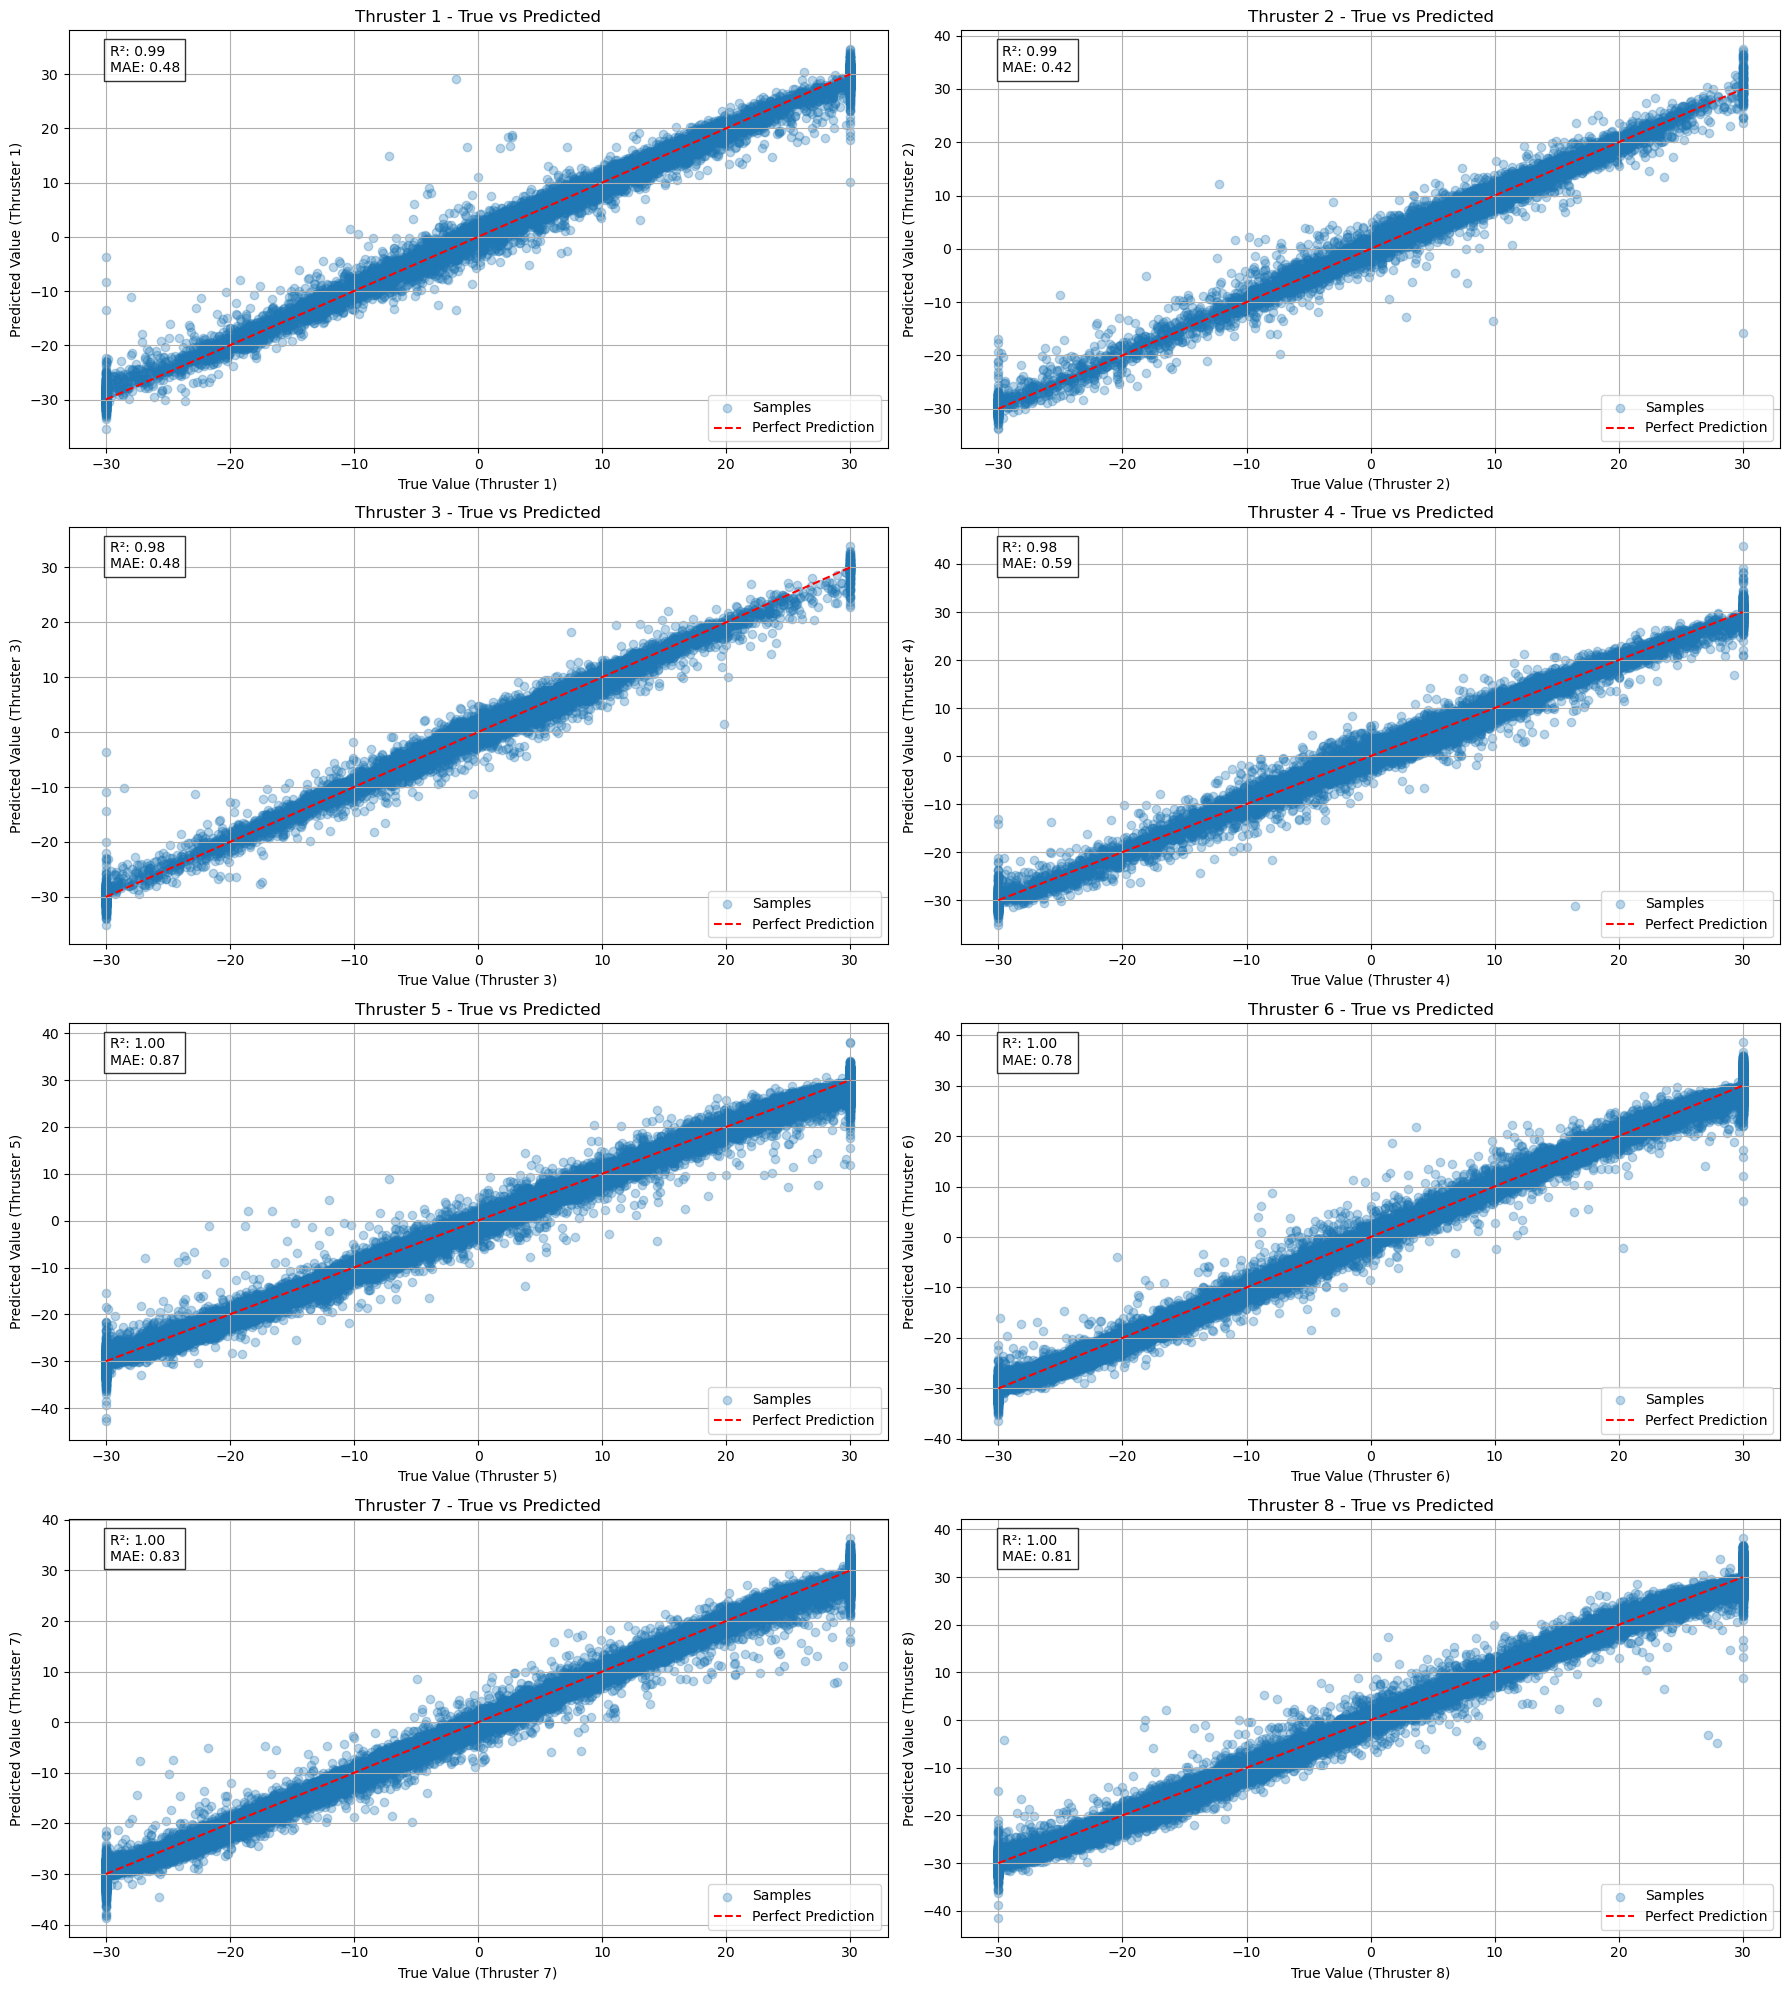

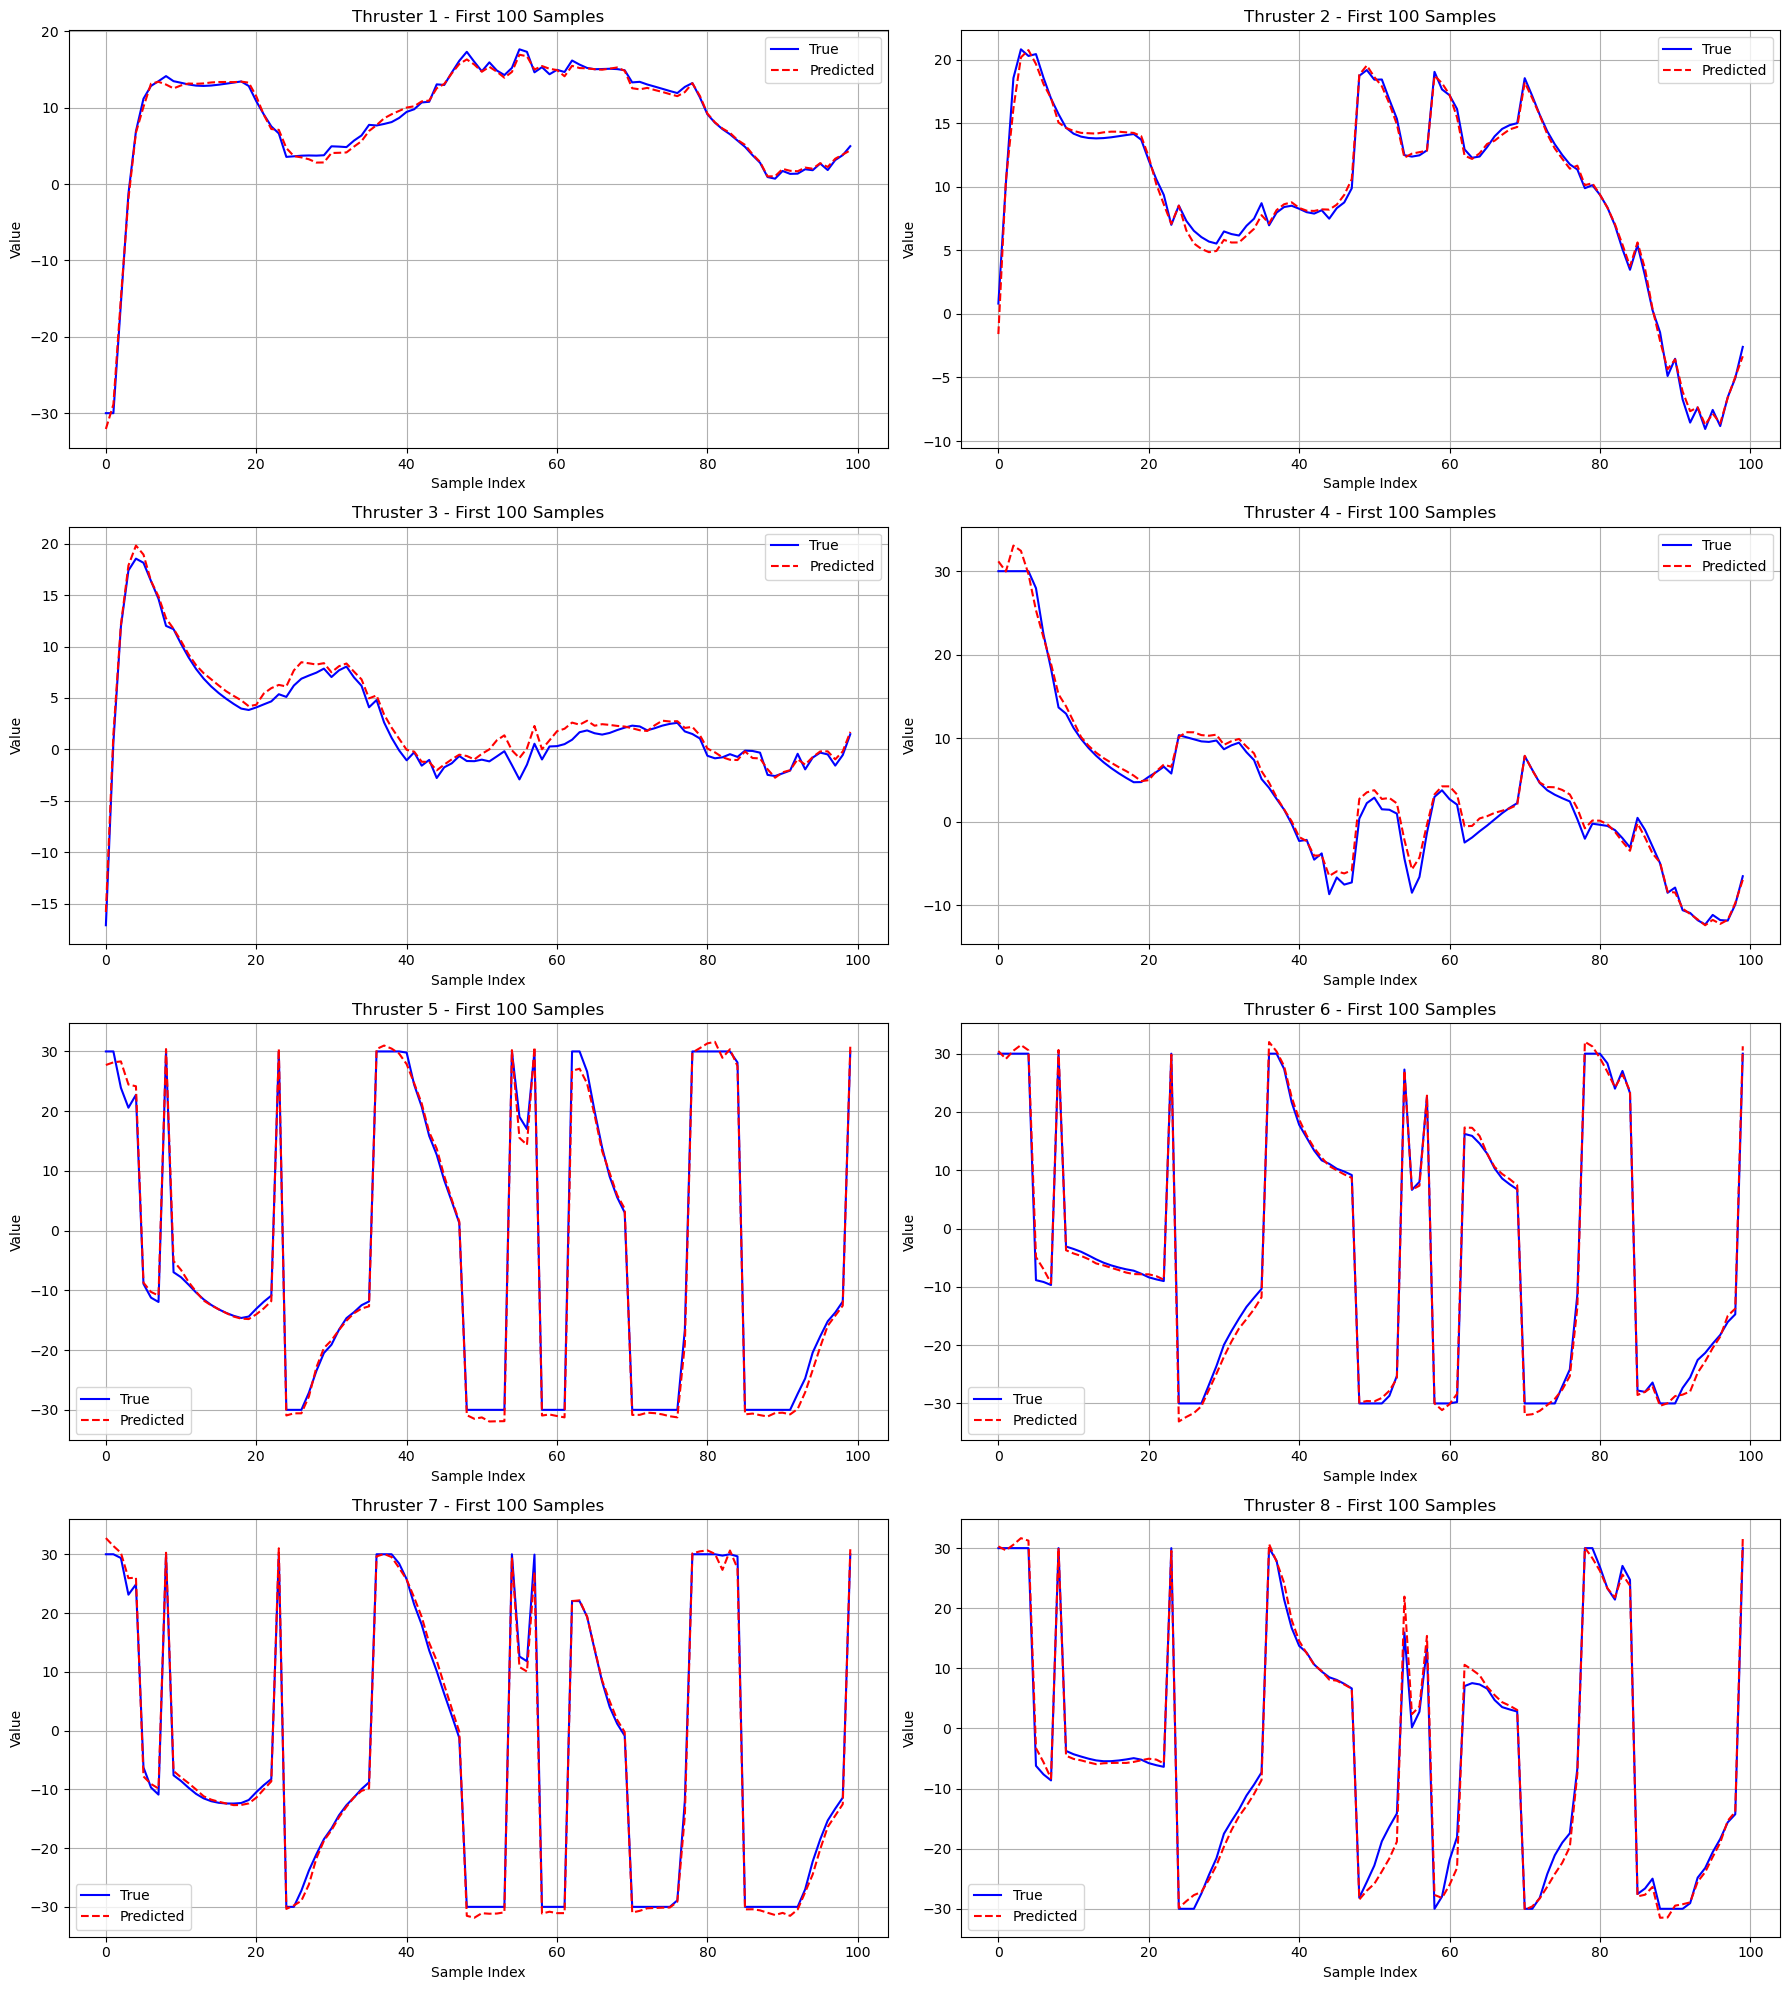

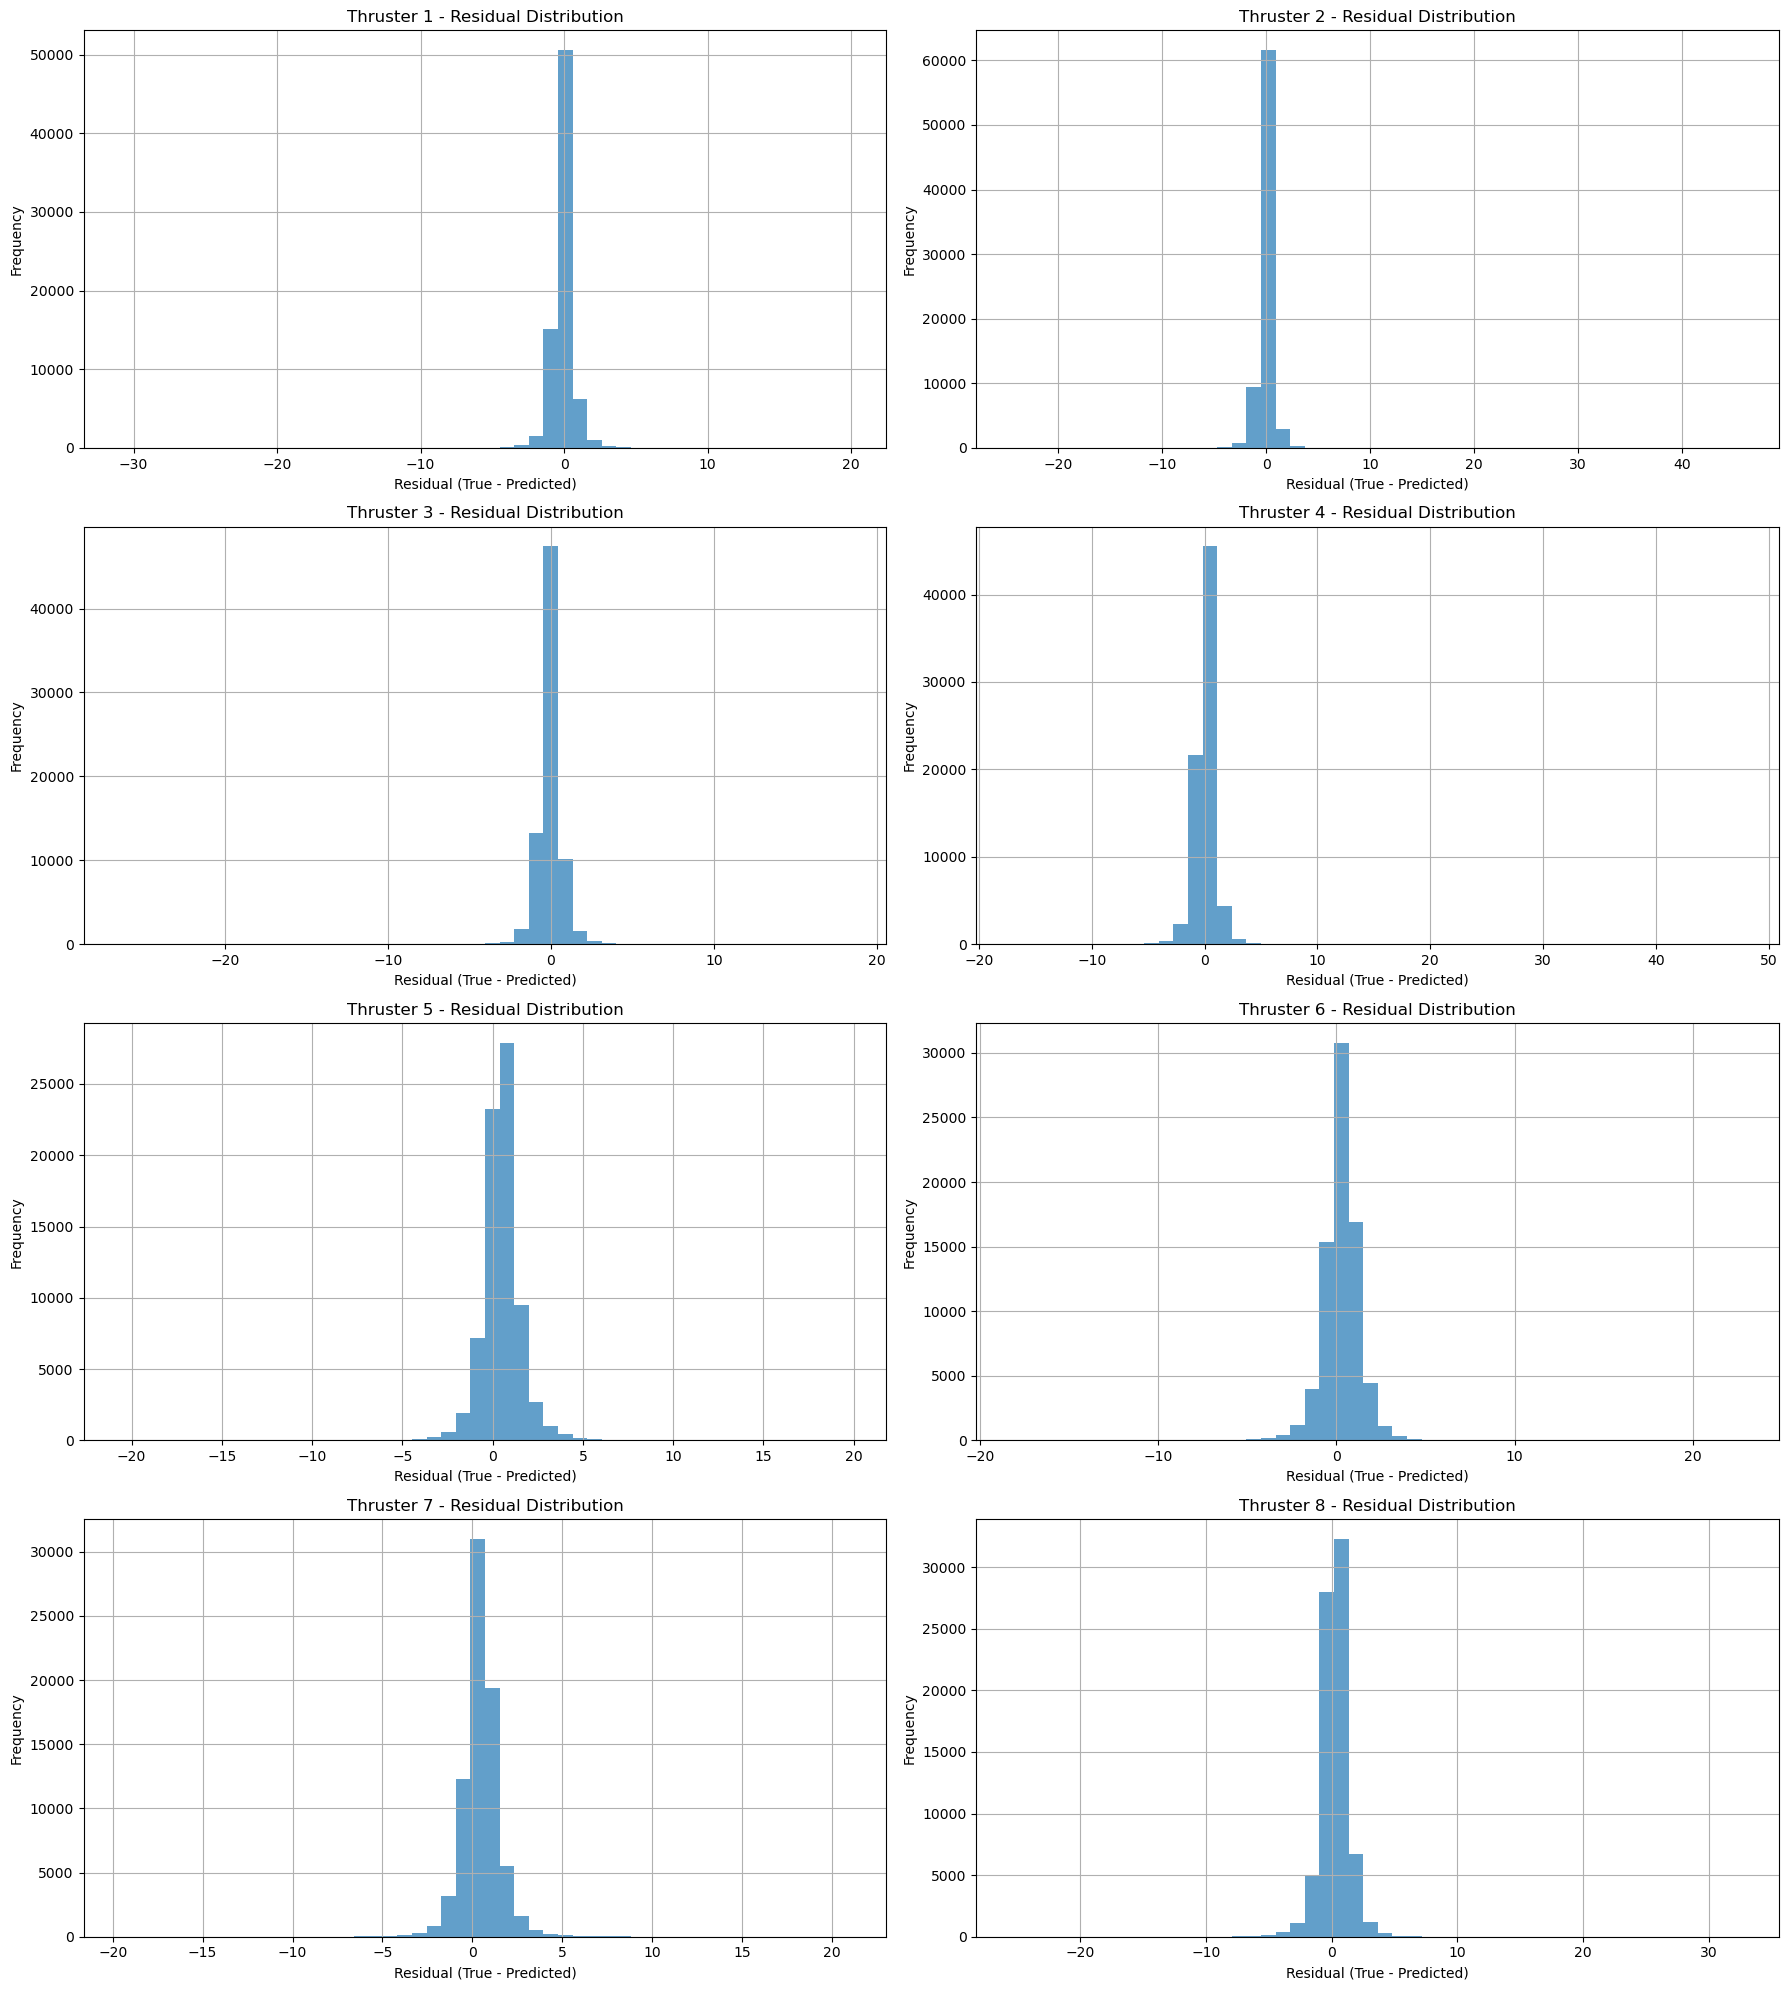

In [9]:
if __name__ == '__main__':
    train(config, train_dataset, val_dataset)

    # Evaluate on test set
    metrics, thruster_metrics, preds, targets = evaluate_test_set()

    print("\nFinal Test Set Metrics:")
    print(f"MAE: {metrics['MAE']:.4f}")
    print(f"MSE: {metrics['MSE']:.4f}")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"R²: {metrics['R2']:.4f}")

    print("\nPer-Thruster Metrics:")
    for tm in thruster_metrics:
        print(f"\nThruster {tm['Thruster']}:")
        print(f"MAE: {tm['MAE']:.4f}  MSE: {tm['MSE']:.4f}")
        print(f"RMSE: {tm['RMSE']:.4f}  R²: {tm['R2']:.4f}")

    visualize_results(targets, preds)